# Integrating Social Media Sentiment into Stock Market Forecasting

**Project Advisor:** Prof. Timothy Smith

**Team Name:** Data Ninjas

**Team Members:**
1. Akshitha Katta 
2. Anuraag Gujje 
3. Prudhvi Teja Mamidi
4. Sai Koushik Thatipamula


### Introduction: 
**Business Scenario:** The problem we aim to address is the challenge of accurately predicting stock prices, a crucial task for investors in financial markets. Traditional methods often fail to capture the complex dynamics of market behavior, leading to suboptimal predictions. By leveraging machine learning techniques, particularly multimodal deep learning and sentiment analysis, we seek to improve the accuracy and reliability of stock price forecasts.

**Business Model:** Our business model revolves around offering a cutting-edge stock market prediction service that combines data science expertise with financial insights. We provide a subscription-based platform for investors, financial institutions, and traders seeking accurate and timely predictions to inform their investment decisions. Revenue streams include subscription fees, premium features, and tailored consulting services.

**Objective:** Our primary objective is to develop a robust forecasting system capable of accurately predicting stock prices at both daily and weekly intervals. Specifically, we aim to explore the potential enhancements in model performance by incorporating sentiment analysis from Twitter alongside historical stock data.


### 1. Common Imports

In [1]:
import os
import csv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from pickle import dump,load
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")
seed=1
epoch_num=100

In [2]:
stock_name = 'AAPL'

## 2. Load the Data

In [3]:
tweets_data = pd.read_csv('stock_tweets.csv')
stocks_data = pd.read_csv('stock_yfinance_data.csv')

In [4]:
print(tweets_data.shape)
tweets_data.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [5]:
df = tweets_data[tweets_data['Stock Name'] == stock_name]
print(df.shape)
df.head()

(5056, 4)


,Date,Tweet,Stock Name,Company Name
55958,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.
55959,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.
55960,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.
55961,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.
55962,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.


In [6]:
print(stocks_data.shape)
stocks_data.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [7]:
stocks_data = stocks_data.drop(columns=['Adj Close','Volume'])

- Dropping the 'Adj Close' and 'Volume' columns from our data set. 
- The 'Adj Close' column represents the adjusted closing price of the stock. Since the 'Close' column already represents the closing price of the stock on a given day, including both 'Close' and 'Adj Close' columns in the input features might introduce redundancy.
- The 'Volume' column represents the trading volume of the stock. While trading volume can provide valuable information about market activity and liquidity, it might not directly influence the prediction of the closing price.

### 3. Sentiment Score for Stock Ticker

In [8]:
sentiment_df = df.copy()
sentiment_df["sentiment_score"] = ''
sentiment_df["Negative"] = ''
sentiment_df["Neutral"] = ''
sentiment_df["Positive"] = ''
sentiment_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
55958,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.,,,,
55959,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.,,,,
55960,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.,,,,
55961,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.,,,,
55962,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.,,,,


We employ the **VADER (Valence Aware Dictionary for Sentiment Reasoning)** model to determine sentiment (polarity) scores in text. VADER is designed for text sentiment analysis and is attuned to both the polarity (positive/negative) and intensity (strength) of emotions. It is a component of the NLTK package and is applicable to unlabeled text data.

In VADER sentiment analysis, a lexicon containing words mapped to emotion intensities, termed sentiment scores, is utilized. These scores represent the strength of emotions associated with each word. By summing the intensity of individual words in the text, VADER computes a sentiment score, offering insights into the overall sentiment conveyed. This methodology enables nuanced sentiment analysis without the need for pre-labeled data.

In [9]:
sentiment_scorer = SentimentIntensityAnalyzer()
for i, row in sentiment_df.T.iteritems():
    try:
        i_tweet = unicodedata.normalize('NFKD', sentiment_df.loc[i, 'Tweet'])
        tweet_sentiment = sentiment_scorer.polarity_scores(i_tweet)
        sentiment_df.at[i, 'sentiment_score'] = tweet_sentiment['compound']
        sentiment_df.at[i, 'Negative'] = tweet_sentiment['neg']
        sentiment_df.at[i, 'Neutral'] = tweet_sentiment['neu']
        sentiment_df.at[i, 'Positive'] = tweet_sentiment['pos']
    except TypeError:
        print (sentiment_df.loc[indexx, 'Tweet'])
        print (i)
        break

In [10]:
sentiment_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
55958,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.,0.25,0.158,0.684,0.158
55959,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.,0.3612,0.0,0.915,0.085
55960,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.,0.0,0.0,1.0,0.0
55961,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.,-0.25,0.182,0.699,0.119
55962,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.,-0.6523,0.143,0.857,0.0


In [11]:
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df['Date'] = sentiment_df['Date'].dt.date
sentiment_df = sentiment_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])

In [12]:
sentiment_df.head()

,Date,Tweet,sentiment_score
55958,2022-09-29,$NIO just because I'm down money doesn't mean ...,0.25
55959,2022-09-29,After trading for 9+ years \n\nThis is how to ...,0.3612
55960,2022-09-29,Not something you see very often. \n-2 ATR mo...,0.0
55961,2022-09-29,$AAPL was down almost 5% today. Rare to see it...,-0.25
55962,2022-09-29,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,-0.6523


In [13]:
final_sentiment_df = pd.DataFrame(sentiment_df.groupby('Date')['sentiment_score'].mean())
final_sentiment_df.rename(columns={"sentiment_score":"score_mean"},inplace=True)
final_sentiment_df['score_sum'] = sentiment_df.groupby('Date')['sentiment_score'].sum()
final_sentiment_df['twt_count'] = sentiment_df.groupby('Date')['sentiment_score'].count()

print(final_sentiment_df.shape)
final_sentiment_df.head()

(365, 3)


,score_mean,score_sum,twt_count
Date,,,
2021-09-30,0.098900,0.6923,7
2021-10-01,0.291891,3.2108,11
2021-10-02,0.007525,0.0301,4
2021-10-03,0.834400,0.8344,1
2021-10-04,0.047410,0.4741,10


In [14]:
stock_df = stocks_data[stocks_data['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date
stock_df.head()

,Date,Open,High,Low,Close,Stock Name
1764,2021-09-30,143.660004,144.380005,141.279999,141.500000,AAPL
1765,2021-10-01,141.899994,142.919998,139.110001,142.649994,AAPL
1766,2021-10-04,141.759995,142.210007,138.270004,139.139999,AAPL
1767,2021-10-05,139.490005,142.240005,139.360001,141.110001,AAPL
1768,2021-10-06,139.470001,142.149994,138.369995,142.000000,AAPL


In [15]:
stock_sentiment_df = stock_df.join(final_sentiment_df, how="left", on="Date")
stock_sentiment_df = stock_sentiment_df.drop(columns=['Stock Name'])
print(stock_sentiment_df.shape)

(252, 8)


In [16]:
stock_sentiment_df.head()

,Date,Open,High,Low,Close,score_mean,score_sum,twt_count
1764,2021-09-30,143.660004,144.380005,141.279999,141.500000,0.098900,0.6923,7
1765,2021-10-01,141.899994,142.919998,139.110001,142.649994,0.291891,3.2108,11
1766,2021-10-04,141.759995,142.210007,138.270004,139.139999,0.047410,0.4741,10
1767,2021-10-05,139.490005,142.240005,139.360001,141.110001,0.139060,0.6953,5
1768,2021-10-06,139.470001,142.149994,138.369995,142.000000,0.190330,1.9033,10


### 4. Closing Price Visualization

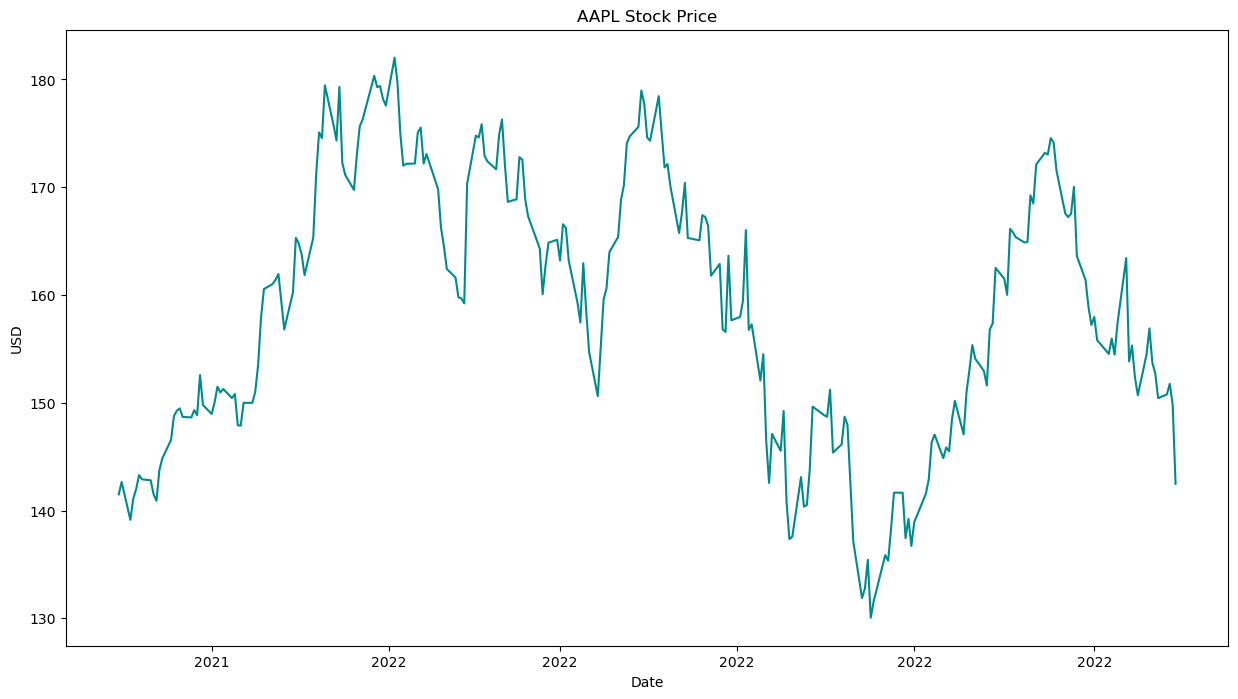

In [17]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(stock_sentiment_df['Date'], stock_sentiment_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

### 5. Feature Engineering

To provide a comprehensive view of market dynamics, we incorporate various technical indicators into the training dataset. These indicators offer insights not only into the current stock price but also into its historical trends over the past week or longer periods.

**Moving Averages**: Moving Averages are computed by averaging the closing prices over a specified number of days. For instance, the average closing price over the past 7 and 20 days.

**Exponential Moving Average**: EMA provides a weighted average of the closing prices, placing more emphasis on recent data points. It is calculated iteratively, considering both the previous EMA value and the current closing price.

**Bollinger Bands**: Bollinger Bands are a volatility indicator consisting of three lines: the middle line, the upper band, and the lower band. The middle line represents the MA(20), while the upper and lower bands are derived from the standard deviation of the moving average. Typically, the upper band is calculated as MA(20) plus two times the standard deviation, while the lower band is calculated as MA(20) minus two times the standard deviation.

By incorporating these technical indicators into our dataset, we aim to provide our model with a comprehensive set of features that capture both short-term fluctuations and long-term trends in stock prices. This enriched dataset will enable our neural network to better understand and interpret the underlying patterns in the market data, ultimately enhancing its predictive capabilities.

In [18]:
def feature_eng(data):
    # Create simple moving average
    data['mov_avg7'] = data.iloc[:,4].rolling(window=7).mean() #Close column

    # Create Bollinger Bands
    data['middle_line'] = data.iloc[:,4].rolling(window=20).mean()
    data['std_dev'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['middle_line'] + (data['std_dev'] * 2)
    data['lower_band'] = data['middle_line'] - (data['std_dev'] * 2)

    # Create Exponential moving average
    data['exp_mov_avg'] = data.iloc[:,4].ewm(com=0.5).mean()

    return data

In [19]:
feature_df = feature_eng(stock_sentiment_df)
dataset = feature_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,score_mean,score_sum,twt_count,mov_avg7,middle_line,std_dev,upper_band,lower_band,exp_mov_avg
0,2021-10-28,149.820007,153.169998,149.720001,152.570007,0.025634,0.7434,29,149.544288,145.351999,3.815009,152.982017,137.721981,151.359926
1,2021-10-29,147.220001,149.940002,146.410004,149.800003,0.205803,6.1741,30,149.621432,145.709499,3.882887,153.475272,137.943726,150.319977
2,2021-11-01,148.990005,149.699997,147.800003,148.960007,0.250989,2.2589,9,149.547147,146.200500,3.620448,153.441395,138.959604,149.413330
3,2021-11-02,148.660004,151.570007,148.649994,150.020004,0.237369,3.0858,13,149.737148,146.646000,3.507520,153.661040,139.630960,149.817780
4,2021-11-03,150.389999,151.970001,149.820007,151.490005,0.036300,0.2178,6,150.144291,147.120500,3.487778,154.096056,140.144945,150.932597


In [20]:
def close_features_visualization(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['mov_avg7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['exp_mov_avg'], label='Exp Moving Average', color='y', linestyle='-.')
    ax.plot(dataset['Date'], dataset['middle_line'], label='middle_line', color='r', linestyle='-.')
    ax.plot(dataset['Date'], dataset['upper_band'], label='upper_band', color='grey', linestyle='-.')
    ax.plot(dataset['Date'], dataset['lower_band'], label='lower_band', color='grey', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

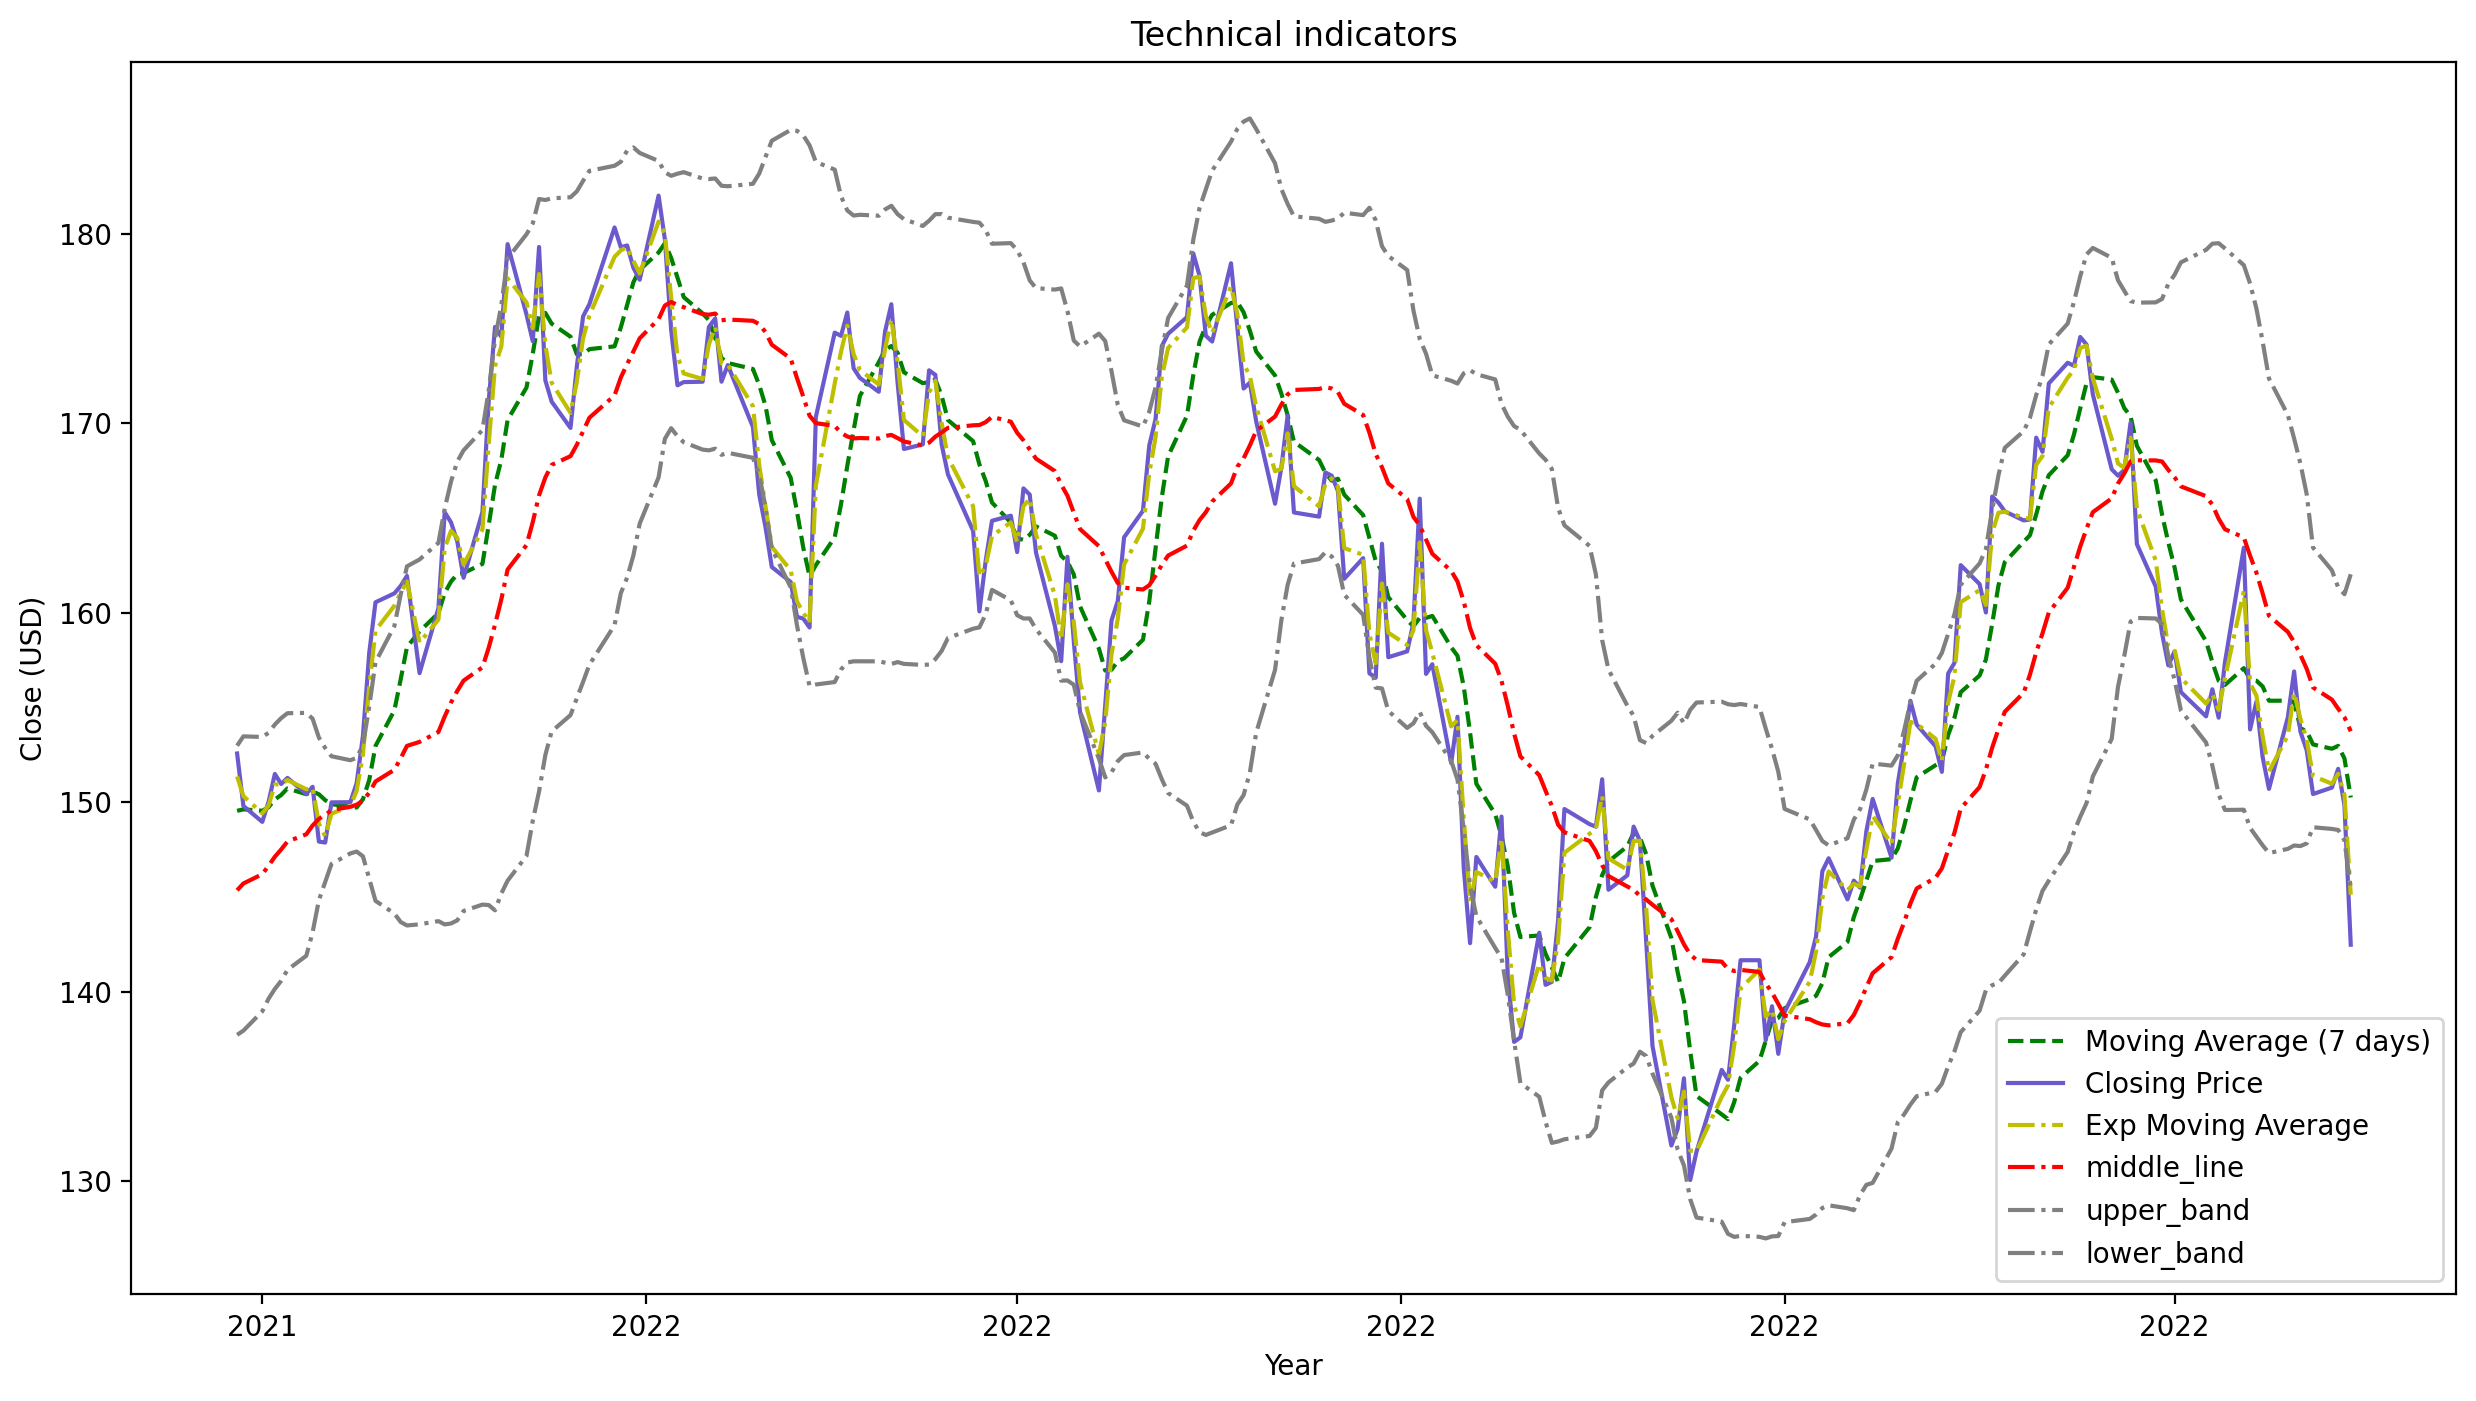

In [21]:
close_features_visualization(dataset)

### 6. Final Dataset

In [22]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [23]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
final_df = dataset.drop(columns='Date')

In [24]:
final_df.head()

,Open,High,Low,Close,score_mean,score_sum,twt_count,mov_avg7,middle_line,std_dev,upper_band,lower_band,exp_mov_avg
2021-10-28,149.820007,153.169998,149.720001,152.570007,0.025634,0.7434,29,149.544288,145.351999,3.815009,152.982017,137.721981,151.359926
2021-10-29,147.220001,149.940002,146.410004,149.800003,0.205803,6.1741,30,149.621432,145.709499,3.882887,153.475272,137.943726,150.319977
2021-11-01,148.990005,149.699997,147.800003,148.960007,0.250989,2.2589,9,149.547147,146.200500,3.620448,153.441395,138.959604,149.413330
2021-11-02,148.660004,151.570007,148.649994,150.020004,0.237369,3.0858,13,149.737148,146.646000,3.507520,153.661040,139.630960,149.817780
2021-11-03,150.389999,151.970001,149.820007,151.490005,0.036300,0.2178,6,150.144291,147.120500,3.487778,154.096056,140.144945,150.932597


In [25]:
selected_columns = final_df.iloc[:, 4]

# Drop selected columns from original DataFrame
final_df = final_df.drop(columns=final_df.columns[4:7])
final_df = final_df.drop(columns=final_df.columns[6])

# Concatenate selected columns to the end of the DataFrame
final_df = pd.concat([final_df, selected_columns], axis=1)

final_df['score_mean'] = final_df['score_mean'].shift(periods=-1)

In [26]:
final_df.head()

,Open,High,Low,Close,mov_avg7,middle_line,upper_band,lower_band,exp_mov_avg,score_mean
2021-10-28,149.820007,153.169998,149.720001,152.570007,149.544288,145.351999,152.982017,137.721981,151.359926,0.205803
2021-10-29,147.220001,149.940002,146.410004,149.800003,149.621432,145.709499,153.475272,137.943726,150.319977,0.250989
2021-11-01,148.990005,149.699997,147.800003,148.960007,149.547147,146.200500,153.441395,138.959604,149.413330,0.237369
2021-11-02,148.660004,151.570007,148.649994,150.020004,149.737148,146.646000,153.661040,139.630960,149.817780,0.036300
2021-11-03,150.389999,151.970001,149.820007,151.490005,150.144291,147.120500,154.096056,140.144945,150.932597,0.098073


### 7. Normalization (Min Max Scaling)

Data scaling for LSTM is essential because it uses activation functions like sigmoid and tanh, which are sensitive to the magnitude of input values. Min-max scaling, is one of the common techniques used to scale the data for LSTM models.

In [27]:
scaler = MinMaxScaler()
scaler = scaler.fit(final_df)
final_df_scaled = scaler.transform(final_df)

scaler_inv = MinMaxScaler()
scaler_inv.fit_transform(final_df.loc[:,['Close']])

final_df_scaled

array([[0.37576105, 0.41107809, 0.41293944, ..., 0.25128223, 0.40319238,
        0.66370595],
       [0.32629366, 0.34718105, 0.34684524, ..., 0.25646813, 0.38199576,
        0.70444372],
       [0.35996954, 0.34243317, 0.37460082, ..., 0.28022619, 0.36351614,
        0.6921647 ],
       ...,
       [0.43131658, 0.44174086, 0.41753201, ..., 0.50418514, 0.40601344,
        0.43995765],
       [0.33428449, 0.36102866, 0.31549526, ..., 0.49128122, 0.38347955,
        0.49492413],
       [0.30498477, 0.28348172, 0.23242809, ..., 0.4321984 , 0.27595872,
               nan]])

### 8. Reshaping Input Data for LSTM Networks

Reshaping the input data for LSTM networks to fit the required format: n_samples x timesteps x n_features.

In [28]:
train_X = []
train_Y = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

for i in range(n_past, len(final_df_scaled) - n_future +1):
    train_X.append(final_df_scaled[i - n_past:i, 0:final_df.shape[1]])
    train_Y.append(final_df_scaled[i + n_future - 1:i + n_future,[3]])

train_X, train_Y = np.array(train_X), np.array(train_Y)

print('TrainX shape = {}.'.format(train_X.shape))
print('TrainY shape = {}.'.format(train_Y.shape))

TrainX shape = (227, 5, 10).
TrainY shape = (227, 1, 1).


### 9. Splitting Data

We split the data into training, validation and testing sets for LSTM models. Two sets of splits are performed: one for the dataset without Twitter data and another for the dataset including Twitter data.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train_X[:,:,:-1], train_Y, test_size=0.2, shuffle=False)

X_train_twt, X_test_twt, y_train_twt, y_test_twt = train_test_split(train_X, train_Y, test_size=0.2, shuffle=False)

X_train.shape,X_train_twt.shape

((181, 5, 9), (181, 5, 10))

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

X_train_twt, X_val_twt, y_train_twt, y_val_twt = train_test_split(X_train_twt, y_train_twt, test_size=0.1, shuffle=False)

X_train.shape,X_train_twt.shape

((162, 5, 9), (162, 5, 10))

### 10. Model Architechture

In [31]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    model.add(MaxPooling1D(pool_size=1, strides=2))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    
    return model

In [32]:
# fit the model

model=build_model((X_train.shape[1],X_train.shape[2]))
model_twt=build_model((X_train_twt.shape[1],X_train_twt.shape[2]))

history = model.fit(X_train, y_train, epochs=epoch_num, batch_size=64, validation_data=(X_val, y_val), verbose=1, )
history_twt = model_twt.fit(X_train_twt, y_train_twt, epochs=epoch_num, batch_size=64, validation_data=(X_val_twt, y_val_twt), verbose=1, )

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 128)         │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 512)         │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 1, 512)         │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 64)          │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,284,097 (8.71 MB)

 Trainable params: 2,284,097 (8.71 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 4, 128)         │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 1, 512)         │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 1, 512)         │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1, 64)          │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,284,353 (8.71 MB)

 Trainable params: 2,284,353 (8.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 633ms/step - loss: 0.3655 - val_loss: 0.0373
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0712 - val_loss: 0.0034
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0565 - val_loss: 0.0219
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0512 - val_loss: 0.0221
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0441 - val_loss: 0.0065
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0183 - val_loss: 0.0032
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0309 - val_loss: 0.0040
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0152 - val_loss: 0.0076
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0227 - val_loss: 0.0055
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0158 - val_loss: 0.0029
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0165 - val_loss: 0.0029
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0156 - val_

Epoch 70/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0066 - val_loss: 0.0024
Epoch 71/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0062 - val_loss: 0.0024
Epoch 72/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0063 - val_loss: 0.0024
Epoch 73/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0057 - val_loss: 0.0024
Epoch 74/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0059 - val_loss: 0.0024
Epoch 75/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0060 - val_loss: 0.0024
Epoch 76/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 77/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0063 - val_loss: 0.0025
Epoch 78/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0063 - val_loss: 0.0025
Epoch 79/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 80/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0070 - val_loss: 0.0025
Epoch 81/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0055

Epoch 39/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0071 - val_loss: 0.0039
Epoch 40/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0068 - val_loss: 0.0040
Epoch 41/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0079 - val_loss: 0.0040
Epoch 42/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0067 - val_loss: 0.0041
Epoch 43/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0072 - val_loss: 0.0042
Epoch 44/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0070 - val_loss: 0.0042
Epoch 45/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0063 - val_loss: 0.0046
Epoch 46/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0071 - val_loss: 0.0043
Epoch 47/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0072 - val_loss: 0.0045
Epoch 48/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0062 - val_loss: 0.0044
Epoch 49/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 50/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0068

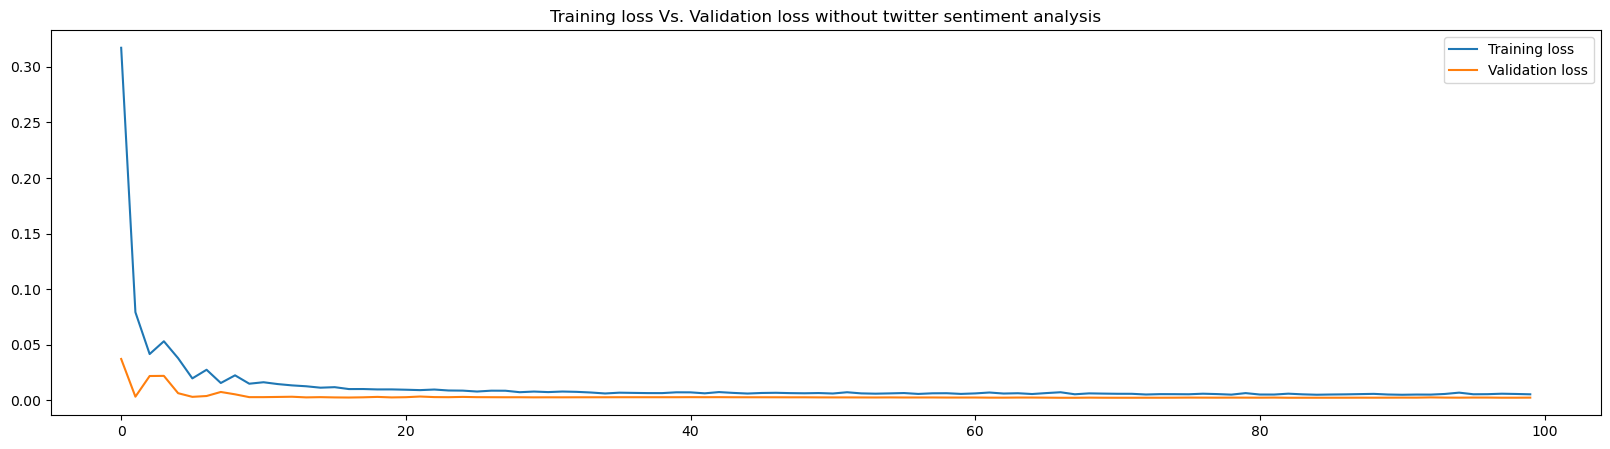

In [33]:
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without twitter sentiment analysis')
plt.legend()

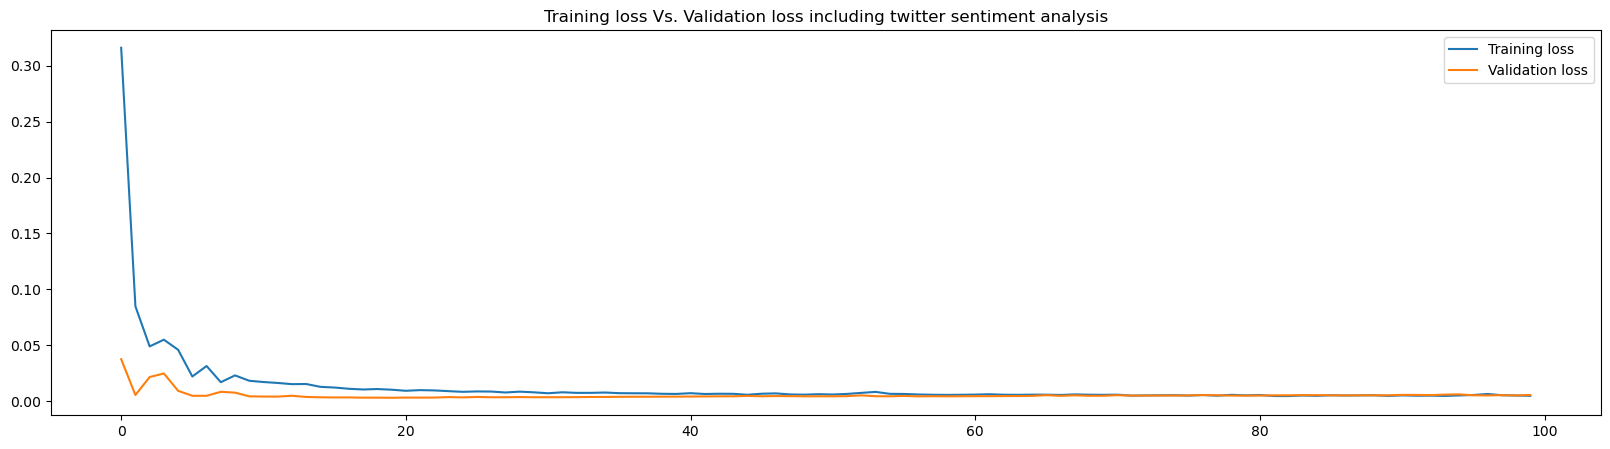

In [34]:
plt.figure(figsize=(20,5))
plt.plot(history_twt.history['loss'], label='Training loss')
plt.plot(history_twt.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including twitter sentiment analysis')
plt.legend()

### 11. Evaluating the Model

In [35]:
def evaluate_model (type,twt,dates,y_actual,y_pred):
    pred_features=['Close']
    for i,pred_features in enumerate(pred_features):
        plt.figure(figsize=(15,6))
        if twt :
            plt.title(f'LSTM {type} prediction of {pred_features} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {pred_features} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual[:,i], label='Actual')
        sns.lineplot(x=dates, y=y_pred[:, i], label='Predicted')
        plt.show()
        error = mean_squared_error(y_actual[:,i], y_pred[:, i])
        print(f'Mean square error for {pred_features} ={error}')

#### 11.A. Training accuracy

In [36]:
train_dts= final_df.index[:X_train.shape[0]]

#Make prediction
train_pred = model.predict(X_train)
train_pred_twt = model_twt.predict(X_train_twt)

train_pred=train_pred.reshape(train_pred.shape[0], train_pred.shape[2])
train_pred_twt=train_pred_twt.reshape(train_pred_twt.shape[0], train_pred_twt.shape[2])

y_train_pred = scaler_inv.inverse_transform(train_pred)
y_train_pred_twt = scaler_inv.inverse_transform(train_pred_twt)

y_train_reshaped=y_train.reshape(y_train.shape[0], y_train.shape[2])
y_train_actual = scaler_inv.inverse_transform(y_train_reshaped)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step


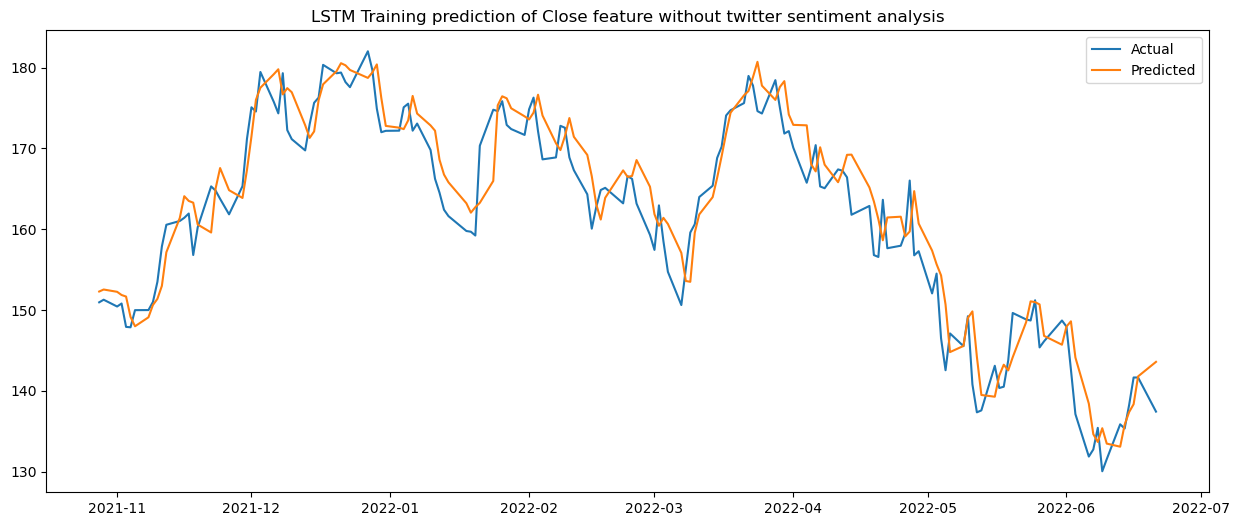

Mean square error for Close =14.241772365050656


In [37]:
evaluate_model('Training',False,train_dts,y_train_actual,y_train_pred)

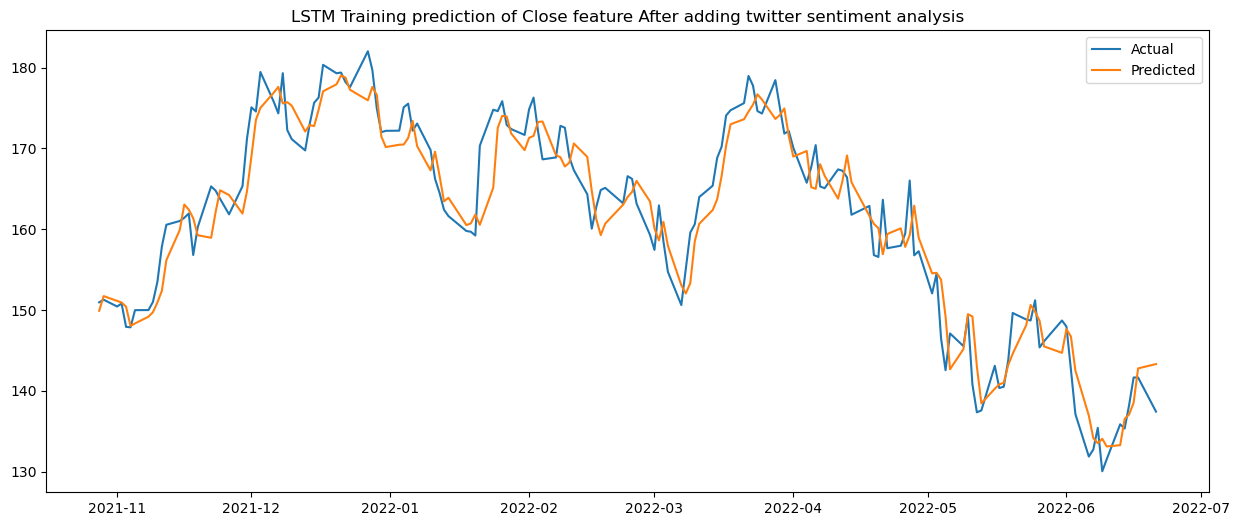

Mean square error for Close =11.616710289277966


In [38]:
evaluate_model('Training',True,train_dts,y_train_actual,y_train_pred_twt)

#### 11.B. Validation accuracy

In [39]:
valid_dts= final_df.index[X_train.shape[0]:X_train.shape[0] + X_val.shape[0]]

#Make prediction
valid_pred = model.predict(X_val)
valid_pred_twt = model_twt.predict(X_val_twt)

valid_pred=valid_pred.reshape(valid_pred.shape[0], valid_pred.shape[2])
valid_pred_twt=valid_pred_twt.reshape(valid_pred_twt.shape[0], valid_pred_twt.shape[2])

y_val_pred = scaler_inv.inverse_transform(valid_pred)
y_val_pred_twt = scaler_inv.inverse_transform(valid_pred_twt)

y_val_actual_reshaped=y_val.reshape(y_val.shape[0], y_val.shape[2])
y_val_actual = scaler_inv.inverse_transform(y_val_actual_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


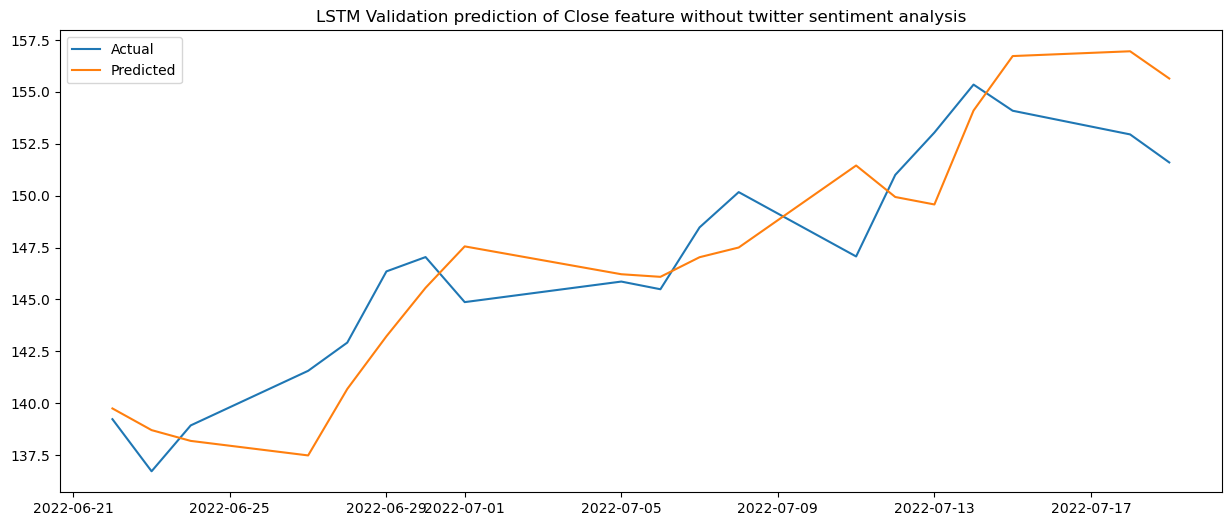

Mean square error for Close =6.760217913475476


In [40]:
evaluate_model('Validation',False,valid_dts,y_val_actual,y_val_pred)

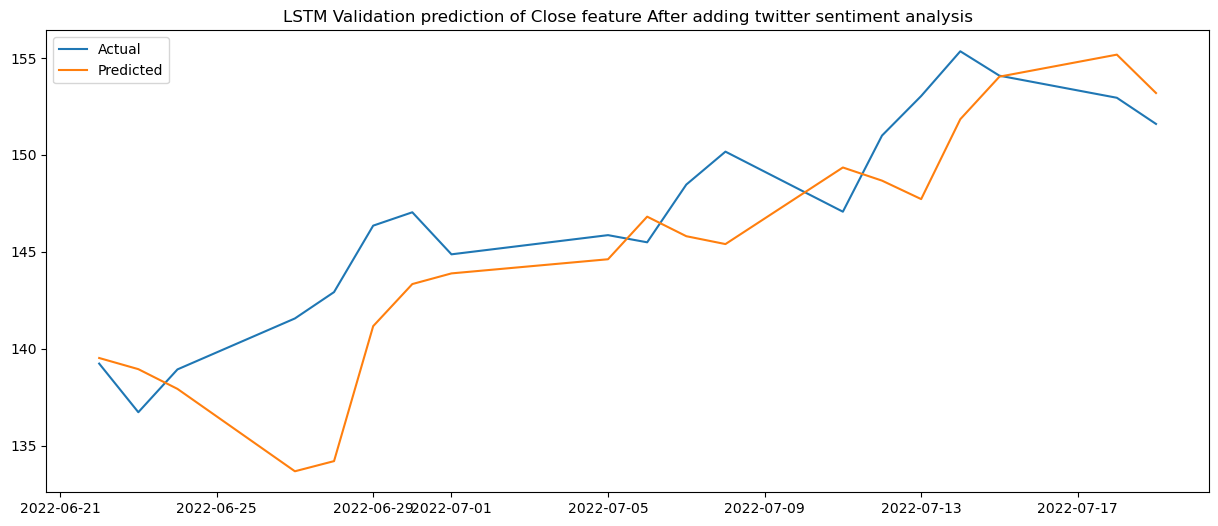

Mean square error for Close =14.624285079109924


In [41]:
evaluate_model('Validation',True,valid_dts,y_val_actual,y_val_pred_twt)

#### 11.C. Test accuracy

In [42]:
test_dts= final_df.index[-X_test.shape[0]:]

#Make prediction
test_pred = model.predict(X_test)
test_pred_twt = model_twt.predict(X_test_twt)

test_pred=test_pred.reshape(test_pred.shape[0], test_pred.shape[2])
test_pred_twt=test_pred_twt.reshape(test_pred_twt.shape[0], test_pred_twt.shape[2])

y_test_pred = scaler_inv.inverse_transform(test_pred)
y_test_pred_twt = scaler_inv.inverse_transform(test_pred_twt)

y_test_actual_reshaped=y_test.reshape(y_test.shape[0], y_test.shape[2])
y_test_actual = scaler_inv.inverse_transform(y_test_actual_reshaped)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


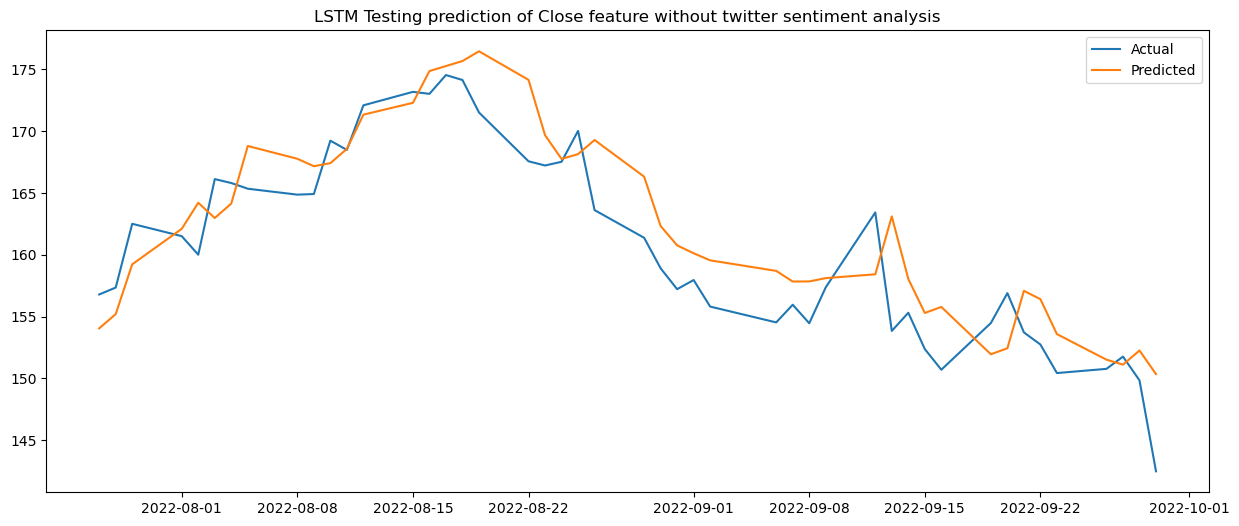

Mean square error for Close =12.67018370940755


In [43]:
evaluate_model('Testing',False,test_dts,y_test_actual,y_test_pred)

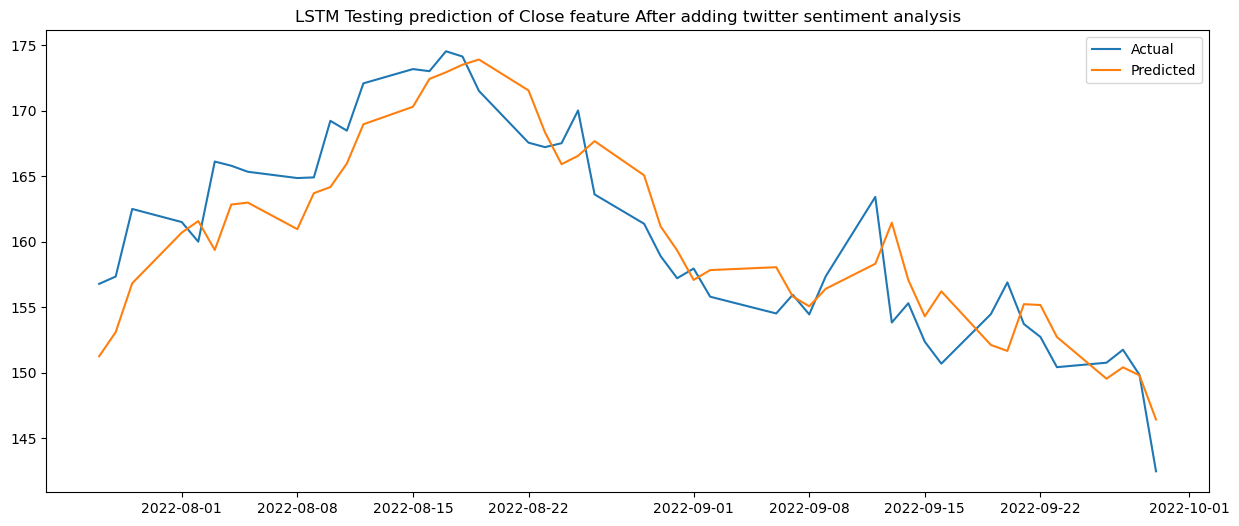

Mean square error for Close =10.799316947672354


In [44]:
evaluate_model('Testing',True,test_dts,y_test_actual,y_test_pred_twt)

### 12. Conclusion

#### Project Overview:
The project aims to predict stock prices using LSTM (Long Short-Term Memory) neural networks. It incorporates technical indicators such as moving averages, exponential moving averages, and Bollinger Bands, along with sentiment analysis of Twitter data, to enhance the predictive capabilities of the models.

#### Comprehensive Process Overview:
1. **Data Collection**: Stock price data is sourced from Yahoo Finance, while Twitter data related to specific stock tickers is obtained through web scraping.
2. **Data Preprocessing**: Involves cleaning, filtering, and organizing the data. This includes handling missing values and normalizing numerical features.
3. **Sentiment Analysis**: The Twitter text data is preprocessed and run through VADER model to determine sentiment (polarity) scores in text.
4. **Feature Engineering**: Technical indicators like moving averages and Bollinger Bands are computed from the stock price data. 
5. **Normalization**: Min-max scaling is applied to scale the data, which is essential for LSTM models.
6. **Model Architecture**: LSTM neural networks are constructed, incorporating convolutional layers, max-pooling layers, bidirectional LSTM layers, dropout layers, and dense layers.
7. **Model Training**: The models are trained on the training dataset using both stock price data alone and stock price data combined with Twitter sentiment analysis.
8. **Model Evaluation**: The trained models are evaluated on separate validation and testing datasets to assess their performance. Mean squared error (MSE) is calculated to quantify prediction accuracy.

#### Conclusion and Interpretations:
- **Performance Comparison**: The LSTM model trained with Twitter sentiment analysis data outperformed the model trained solely on stock price data in terms of MSE. This is expected as Twitter data provides relevant information into latest news and public mood related to the respective company which serves as external factors.
- **Impact of Twitter Sentiment Analysis**: Incorporating sentiment analysis of Twitter data appears to also enhance the model's ability to capture subtle trends and fluctuations in stock prices.
- **Business Scope and Applications**:
  - **Risk Management**: Accurate predictions of stock prices can help in risk management strategies by providing insights into potential market movements and minimizing financial risks.
  - **Market Sentiment Analysis**: Twitter sentiment analysis can be further expanded into stock news APIs to gauge more latest and timely market sentiment and investor sentiment, providing valuable insights for decision-making.
  - **Financial Forecasting**: LSTM models can be utilized for financial forecasting tasks, helping investors and financial institutions make informed decisions about investments and portfolio management.

#### Future Directions:
- **Model Optimization**: Further optimization of model architecture by using more advance and sophisticated neural networks could potentially improve prediction accuracy.
- **Additional External Factors**: Exploring additional external factors and Sources like APIs that provide latest market related news and connecting them to the model could enhance the models' predictive capabilities a lot.
- **Real-time Prediction**: Implementing real-time prediction capabilities to adapt to changing market conditions and provide timely insights.

#### Overall, this project demonstrates the effectiveness of LSTM neural networks in predicting stock prices, particularly when combined with sentiment analysis of social media data. By leveraging these predictive models, stakeholders can make more informed decisions in the dynamic and volatile financial markets.